<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-Libraries" data-toc-modified-id="Importing-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Libraries</a></span></li><li><span><a href="#User-Defined-Functions" data-toc-modified-id="User-Defined-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>User Defined Functions</a></span></li><li><span><a href="#Reading-Data" data-toc-modified-id="Reading-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reading Data</a></span><ul class="toc-item"><li><span><a href="#Checking-the-event-rate" data-toc-modified-id="Checking-the-event-rate-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Checking the event rate</a></span></li></ul></li><li><span><a href="#Displaying-the-attributes" data-toc-modified-id="Displaying-the-attributes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Displaying the attributes</a></span></li><li><span><a href="#Checking-Data-Quality" data-toc-modified-id="Checking-Data-Quality-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Checking Data Quality</a></span></li><li><span><a href="#Missing-Value-Treatment" data-toc-modified-id="Missing-Value-Treatment-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Missing Value Treatment</a></span></li><li><span><a href="#Looking-at-attributes-(EDA)" data-toc-modified-id="Looking-at-attributes-(EDA)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Looking at attributes (EDA)</a></span></li><li><span><a href="#Preparing-Data-for-Modeling" data-toc-modified-id="Preparing-Data-for-Modeling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Preparing Data for Modeling</a></span></li><li><span><a href="#Model-1---XGB-Classifier" data-toc-modified-id="Model-1---XGB-Classifier-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model 1 - XGB Classifier</a></span><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Baseline Model</a></span></li><li><span><a href="#XGB-Classifier-:-Parameter-Tuning" data-toc-modified-id="XGB-Classifier-:-Parameter-Tuning-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>XGB Classifier : Parameter Tuning</a></span></li><li><span><a href="#XGB-Classifier-:-Setting-threshold" data-toc-modified-id="XGB-Classifier-:-Setting-threshold-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>XGB Classifier : Setting threshold</a></span><ul class="toc-item"><li><span><a href="#Getting-optimal-threshold" data-toc-modified-id="Getting-optimal-threshold-9.3.1"><span class="toc-item-num">9.3.1&nbsp;&nbsp;</span>Getting optimal threshold</a></span></li></ul></li></ul></li><li><span><a href="#Model-2---LightGBM" data-toc-modified-id="Model-2---LightGBM-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Model 2 - LightGBM</a></span></li></ul></div>

# HR Analytics : Hackathon Challenge

I participated in WNS Analytics Wizard hackathon, “To predict whether an employee will be promoted or not” and hence I am coming up with this tutorial of the solution submitted which ranked me 150 (Top 12%) in the challenge.

**About Data**
<br/>
The data-set consists of 54808 rows where each row had 14 attributes including target variable (i.e "is_promoted"). There are 4668 cases where employee has been promoted (8.5%).

Let's get started in building the data analytics pipeline end to end.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# Set all options
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (20, 3)
pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set(context="paper", font="monospace")

## User Defined Functions

In [2]:
def convert_categorical_to_dummies(d_convert):
    
    """
    Author: Abhijeet Kumar
    Description: returns Dataframe with all categorical variables converted into dummies
    Arguments: Dataframe (having categorical variables)
    """
    
    df = d_convert.copy()
    list_to_drop = []
    for col in df.columns:
        if df[col].dtype == 'object':
            list_to_drop.append(col)
            df = pd.concat([df,pd.get_dummies(df[col],prefix=col,prefix_sep='_', drop_first=False)], axis=1)    
    df = df.drop(list_to_drop,axis=1)
    return df


def quality_report(df):

    """
    Author: Abhijeet Kumar
    Description: Displays quality of data in terms of missing values, unique numbers, datatypes etc.
    Arguments: Dataframe
    """
    dtypes = df.dtypes
    nuniq = df.T.apply(lambda x: x.nunique(), axis=1)
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    quality_df  = pd.concat([total, percent, nuniq, dtypes], axis=1, keys=['Total', 'Percent','Nunique', 'Dtype'])
    display(quality_df)
    

    
def object_count_plot(df):
    
    """
    Author: Abhijeet Kumar
    Description : Plot countplot for all the objects present in the dataframe passed
    Argument : Dataframe
    """
    
    for var in df.columns:
        if df[var].dtype == 'object':
            print(df[var].value_counts())
            plt.figure(figsize=(12,5))
            g = sns.countplot(x=var,data=df)
            g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
            plt.tight_layout()
            plt.show()
            
def numeric_distribution_plot(df):
    
    """
    Author: Abhijeet Kumar
    Description : Gives distribution plot for all the numeric features in the dataframe passed
    Argument : Dataframe
    """
    
    for col in df.columns:
        if df[col].dtype != 'object':
            print(df[col].describe())
            plt.figure(figsize=(12,5))
            plt.title("Distribution of "+col)
            ax = sns.distplot(df[col].dropna())
            plt.tight_layout()
            plt.show()
            
    
def score_on_test_set(model, file_name, out_name):
    
    """
    Author: Abhijeet Kumar
    Description : It runs same steps of preprocessing as in training, scores 
                  on the test data provided in hackathon and generates the submission file.                   
    Argument : model, test data file, submission file 
    """
    
    test_data = pd.read_csv(file_name)
    
    # Treating the missing values of education as a separate category
    test_data['education'] = test_data['education'].replace(np.NaN, 'NA')
    
    # Treating the missing values of education as a separate category
    test_data['previous_year_rating'] = test_data['previous_year_rating'].fillna(0)
    
    # Creating dummy variables for all the categorical columns, droping that column
    master_test_data = convert_categorical_to_dummies(test_data)
    
    # Removing the id attributes
    df_test_data = master_test_data.drop(['employee_id'],axis=1)
    if out_name == "submission_lightgbm.csv":
        y_pred = model.predict_proba(df_test_data.values, num_iteration=model.best_iteration_)
    else:        
        y_pred = model.predict_proba(df_test_data.values)
    submission_df = pd.DataFrame({'employee_id':master_test_data['employee_id'],'is_promoted':y_pred[:,1]})
    submission_df.to_csv(out_name, index=False)
    
    score = model.predict_proba(df_test_data.values)
    return test_data,score

## Reading Data

In [3]:
data = pd.read_csv("train.csv")
print("Shape of Data = ",data.shape)
data.sample(5)

Shape of Data =  (54808, 14)


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
17816,30788,Operations,region_2,Bachelor's,f,sourcing,1,41,4.0000,7,0,0,59,0
43396,35815,Procurement,region_22,Master's & above,m,sourcing,1,30,2.0000,5,0,0,68,0
24405,51319,Sales & Marketing,region_16,Master's & above,m,other,1,42,1.0000,14,0,0,47,0
50611,48446,Analytics,region_2,Bachelor's,f,sourcing,1,35,5.0000,4,1,1,89,1
41702,1523,Finance,region_31,Bachelor's,m,sourcing,3,26,5.0000,4,1,0,54,0


### Checking the event rate

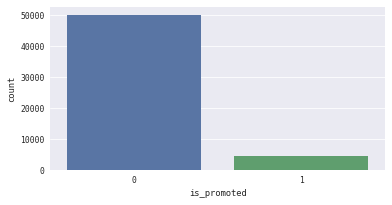

0    50140
1     4668
Name: is_promoted, dtype: int64

In [4]:
plt.figure(figsize=(6,3))
sns.countplot(x='is_promoted',data=data)
plt.show()

# Checking the event rate : event is when claim is made
data['is_promoted'].value_counts()

## Displaying the attributes

In [5]:
# Checking the attribute names
pd.DataFrame(data.columns) 

,0
0,employee_id
1,department
2,region
3,education
4,gender
5,recruitment_channel
6,no_of_trainings
7,age
8,previous_year_rating
9,length_of_service


## Checking Data Quality

In [6]:
# checking missing data
quality_report(data)

,Total,Percent,Nunique,Dtype
KPIs_met >80%,0,0.0000,2,int64
age,0,0.0000,41,int64
avg_training_score,0,0.0000,61,int64
awards_won?,0,0.0000,2,int64
department,0,0.0000,9,object
education,2409,4.3953,3,object
employee_id,0,0.0000,54808,int64
gender,0,0.0000,2,object
is_promoted,0,0.0000,2,int64
length_of_service,0,0.0000,35,int64


## Missing Value Treatment

In [7]:
# Treating the missing values of education as a separate category
data['education'] = data['education'].replace(np.NaN, 'NA')

# Treating the missing values of education as a separate category
data['previous_year_rating'] = data['previous_year_rating'].fillna(0)

In [8]:
# Checking number of unique values in each column, just to confirm if there are multiple values in it.
quality_report(data)

,Total,Percent,Nunique,Dtype
KPIs_met >80%,0,0.0000,2,int64
age,0,0.0000,41,int64
avg_training_score,0,0.0000,61,int64
awards_won?,0,0.0000,2,int64
department,0,0.0000,9,object
education,0,0.0000,4,object
employee_id,0,0.0000,54808,int64
gender,0,0.0000,2,object
is_promoted,0,0.0000,2,int64
length_of_service,0,0.0000,35,int64


## Looking at attributes (EDA)

Can we make some inferences from EDA ?

* Promotions are worst in Legal department (5.1%). Best promotions are in Technology department (10.7%).
* Region 9 is worst (1.9%) and region 4 is best (14.4%) in terms of promotions.
* Although Master's & above has greater promotion percentage but difference is not much.
* Employees having previous years rating greater than 5 will have better chances of promotion than others.
* Employess having KPI greater than 80% has good chances of promotions (16%)
* Employees winning awards are promoted more (44%)

In [9]:
for col in data.drop('is_promoted',axis=1).columns:
    if data[col].dtype == 'object' or data[col].nunique() < 10:
        xx = data.groupby(col)['is_promoted'].value_counts().unstack(1)
        per_not_promoted = xx.iloc[:, 0] *100/xx.apply(lambda x: x.sum(), axis=1)
        per_promoted = xx.iloc[:, 1]*100/xx.apply(lambda x: x.sum(), axis=1)
        xx['%_0'] = per_not_promoted
        xx['%_1'] = per_promoted
        display(xx)

is_promoted,0,1,%_0,%_1
department,,,,
Analytics,4840,512,90.4335,9.5665
Finance,2330,206,91.8770,8.1230
HR,2282,136,94.3755,5.6245
Legal,986,53,94.8989,5.1011
Operations,10325,1023,90.9852,9.0148
Procurement,6450,688,90.3614,9.6386
R&D,930,69,93.0931,6.9069
Sales & Marketing,15627,1213,92.7969,7.2031
Technology,6370,768,89.2407,10.7593


is_promoted,0,1,%_0,%_1
region,,,,
region_1,552,58,90.4918,9.5082
region_10,597,51,92.1296,7.8704
region_11,1241,74,94.3726,5.6274
region_12,467,33,93.4000,6.6000
region_13,2418,230,91.3142,8.6858
region_14,765,62,92.5030,7.4970
region_15,2586,222,92.0940,7.9060
region_16,1363,102,93.0375,6.9625
region_17,687,109,86.3065,13.6935


is_promoted,0,1,%_0,%_1
education,,,,
Bachelor's,33661,3008,91.7969,8.2031
Below Secondary,738,67,91.6770,8.3230
Master's & above,13454,1471,90.1441,9.8559
NA,2287,122,94.9357,5.0643


is_promoted,0,1,%_0,%_1
gender,,,,
f,14845,1467,91.0066,8.9934
m,35295,3201,91.6849,8.3151


is_promoted,0,1,%_0,%_1
recruitment_channel,,,,
other,27890,2556,91.6048,8.3952
referred,1004,138,87.9159,12.0841
sourcing,21246,1974,91.4987,8.5013


is_promoted,0,1,%_0,%_1
previous_year_rating,,,,
0.0000,3785,339,91.7798,8.2202
1.0000,6135,88,98.5859,1.4141
2.0000,4044,181,95.7160,4.2840
3.0000,17263,1355,92.7221,7.2779
4.0000,9093,784,92.0624,7.9376
5.0000,9820,1921,83.6385,16.3615


is_promoted,0,1,%_0,%_1
KPIs_met >80%,,,,
0,34111,1406,96.0413,3.9587
1,16029,3262,83.0906,16.9094


is_promoted,0,1,%_0,%_1
awards_won?,,,,
0,49429,4109,92.3251,7.6749
1,711,559,55.9843,44.0157


## Preparing Data for Modeling

In [10]:
# Creating dummy variables for all the categorical columns, droping that column
master_data = convert_categorical_to_dummies(data)
print("Total shape of Data :",master_data.shape)

Total shape of Data : (54808, 61)


In [11]:
# dropping the target from dataset
labels = np.array(master_data['is_promoted'].tolist())

# Removing the id attributes
df_data = master_data.drop(['is_promoted','employee_id'],axis=1)
print("Shape of Data:",df_data.shape)
df = df_data.values

Shape of Data: (54808, 59)


## Model 1 - XGB Classifier

### Baseline Model

In [12]:
xgb_model = xgb.XGBClassifier()
print(xgb_model)

# Cross validation scores
f1_scores = cross_val_score(xgb_model, df, labels, cv=5, scoring='f1')
print(f1_scores," Mean = ",np.mean(f1_scores))

# Training the models
xgb_model.fit(df,labels)

# Scoring on test set
test_data,score_xgb = score_on_test_set(xgb_model,"test.csv","submission_xgb.csv")    

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
[ 0.4526749   0.41547519  0.43579122  0.43012552  0.43427621]  Mean =  0.433668606717


### XGB Classifier : Parameter Tuning

**It is done to improve the training and increase score in terms of F1-score**

In [13]:
# Create parameters to search
params = {
     'learning_rate': [0.01],
     'n_estimators': [1000],
     'max_depth':[8],
     'reg_alpha':[0.4]
    }

# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier()

# Gridsearch initializaation
gsearch = GridSearchCV(xgb_model, params,
                    verbose=True,
                    cv=5,
                    n_jobs=2)

gsearch.fit(df, labels)

#Printing the best chosen params
print(gsearch.best_params_)

params = {'objective':'binary:logistic', 'booster':'gbtree'}

# Updating the parameter as per grid search
params.update(gsearch.best_params_)

# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier(**params)
print(xgb_model)

# Cross validation scores
f1_scores = cross_val_score(xgb_model, df, labels, cv=5, scoring='f1',n_jobs=2)
print(f1_scores," Mean = ",np.mean(f1_scores))

# Fitting model on tuned parameters
xgb_model.fit(df, labels)

# Scoring on test set
test_data,score_xgb_tuned = score_on_test_set(xgb_model,"test.csv","submission_xgb_tuned.csv")    

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 13.3min finished


{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000, 'reg_alpha': 0.4}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
[ 0.51014041  0.48657188  0.49528302  0.53054911  0.51130164]  Mean =  0.506769210361


### XGB Classifier : Setting threshold

* This is another way by which optimal threshold can be found out to increase F1-score
* We need to find the threshold where f1-score is highest.
* I tried submissions on some of the cut-offs to get highest f1 score in leaderboard.

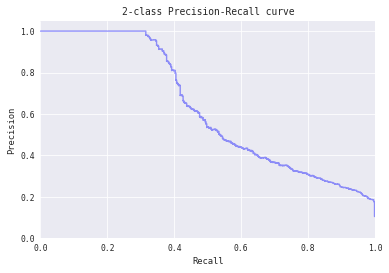

In [18]:
%matplotlib inline

# Splitting the dataset in order to use early stopping round
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.10, stratify=labels)

xgb_model = xgb.XGBClassifier(**params)


# Training the models
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])

thresholds = np.append(thresholds, 1)
f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

#### Getting optimal threshold 

** Once we find the threshold, we can set modify the "submission_xgb_tuned.csv" file by setting predictions 0 and 1 with the found cutoff.**

Threshold cutoff:  0.340377241373
Max F1-score at cut-off :  0.53791130186


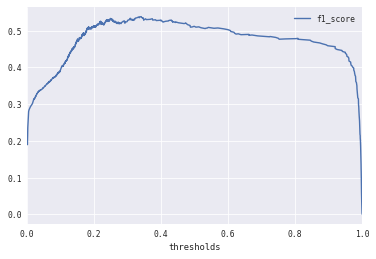

In [19]:
scrs = pd.DataFrame({'precision' : precision, 'recal' : recall, 'thresholds' : thresholds, 'f1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())
scrs.plot(x='thresholds', y='f1_score')

## Model 2 - LightGBM

* Initially, I ran default LightGBM model which itself gave me good f1-score
* Parameter tuning was not helping somehow.
* Setting up early stopping rounds and predicting the results with best iteration boosted the f1-score margianlly.

In [16]:
# Initializing the LightGBM model
gbm_model = lgb.LGBMClassifier(objective='binary')

# Cross validation score 
f1_scores = cross_val_score(gbm_model, df, labels, cv=5, scoring='f1',n_jobs=3)
print(f1_scores," Mean = ",np.mean(f1_scores))

# Splitting the dataset in order to use early stopping round
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.10, stratify=labels)

# Fitting LightGBM model
gbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=150)

# Scoring on test set
test_data,score_lgbm_tuned = score_on_test_set(gbm_model,"test.csv","submission_lightgbm.csv")    

[ 0.51221434  0.4866562   0.49685535  0.52721617  0.50274941]  Mean =  0.505138294776
[1]	valid_0's auc: 0.830009
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's auc: 0.862102
[3]	valid_0's auc: 0.878114
[4]	valid_0's auc: 0.879327
[5]	valid_0's auc: 0.889182
[6]	valid_0's auc: 0.891111
[7]	valid_0's auc: 0.891985
[8]	valid_0's auc: 0.892882
[9]	valid_0's auc: 0.894094
[10]	valid_0's auc: 0.894478
[11]	valid_0's auc: 0.896603
[12]	valid_0's auc: 0.897032
[13]	valid_0's auc: 0.897391
[14]	valid_0's auc: 0.897099
[15]	valid_0's auc: 0.897909
[16]	valid_0's auc: 0.898457
[17]	valid_0's auc: 0.899207
[18]	valid_0's auc: 0.899897
[19]	valid_0's auc: 0.901114
[20]	valid_0's auc: 0.902247
[21]	valid_0's auc: 0.902672
[22]	valid_0's auc: 0.903267
[23]	valid_0's auc: 0.903518
[24]	valid_0's auc: 0.904089
[25]	valid_0's auc: 0.904034
[26]	valid_0's auc: 0.904778
[27]	valid_0's auc: 0.905123
[28]	valid_0's auc: 0.905233
[29]	valid_0's auc: 0.905509
[30]	valid_0's auc:

**One can perform similar hypertuning and cutoff setting with LightGBM and check the F1-scores if it improves**